In [53]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# pip install scipy


In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from natsort import natsorted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import shap
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.transform import Rotation as R

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.signal import correlate
from scipy.fft import fft
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import entropy


In [56]:
# a()

In [57]:


def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
    """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
    upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
                        f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
    wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
                       f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

    vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
    vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

    dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
    norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
    return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()

def window_feature_extraction(window):
    """Trích xuất tất cả đặc trưng cho từng cửa sổ"""
    features = {}
    sensors = ['atr01', 'atr02', 'atr03', 'atr04']

    # 1. Thống kê cơ bản
    for s in sensors:
        acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
                          window[f'{s}/acc_y']**2 +
                          window[f'{s}/acc_z']**2)
        gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
                           window[f'{s}/gyro_y']**2 +
                           window[f'{s}/gyro_z']**2)

        for ax in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            features[f'{s}/{ax}_mean'] = window[f'{s}/{ax}'].mean()
            features[f'{s}/{ax}_std'] = window[f'{s}/{ax}'].std()

        features.update({
            f'{s}/acc_mag_avg': acc_mag.mean(),
            f'{s}/gyro_mag_avg': gyro_mag.mean(),
            f'{s}/jerk': acc_mag.diff().mean() * 30
        })

    # 2. Góc khuỷu tay
    features.update({
        'elbow_angle_right': calculate_elbow_angle_quat(window, 'atr03', 'atr01'),
        'elbow_angle_left': calculate_elbow_angle_quat(window, 'atr04', 'atr02')
    })

    # 3. Độ trễ tương quan chéo
    def _calc_lag(s1, s2, axis='acc_z'):
        x = window[f'{s1}/{axis}'].values
        y = window[f'{s2}/{axis}'].values
        if len(x) < 10 or len(y) < 10:
            return 0
        corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
        return np.argmax(corr) - len(y) + 1

    features.update({
        'lag_right_arm': _calc_lag('atr03', 'atr01'),
        'lag_left_arm': _calc_lag('atr04', 'atr02')
    })

    # 4. Đặc trưng tần số và entropy
    for s in sensors:
        sig = window[f'{s}/acc_x'].values
        if len(sig) > 10:
            fft_vals = np.abs(fft(sig))
            features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
        else:
            features[f'{s}/dominant_freq'] = 0

    # 5. Đặc trưng động học nâng cao
    for s in ['atr01', 'atr02']:
        roll = window[f'{s}/roll'].values
        features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

    # 6. Đặc trưng rolling
    window = window.copy()
    for i in [1, 2]:
        sensor = f'atr0{i}'
        window[f'{sensor}/wrist_stability'] = window[f'{sensor}/roll'].rolling(window=10, min_periods=1).std().values
        window[f'{sensor}/stillness'] = (window[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum().values

    # Lấy giá trị cuối cùng của các đặc trưng rolling
    last_row = window.iloc[-1]
    for col in window.columns:
        if 'stability' in col or 'stillness' in col:
            features[col] = last_row[col]

    return features


def process_pipeline(data_path, window_size=30, step_size=15):
    """Pipeline xử lý hoàn chỉnh"""
    df = pd.read_csv(data_path)
    df = df.drop(['Unnamed: 0', 'action'], axis = 1)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # Tiền xử lý cơ bản
    for i in range(1, 5):
        df[f'atr0{i}/acc_mag'] = np.sqrt(df[f'atr0{i}/acc_x']**2 +
                                        df[f'atr0{i}/acc_y']**2 +
                                        df[f'atr0{i}/acc_z']**2)
        df[f'atr0{i}/gyro_mag'] = np.sqrt(df[f'atr0{i}/gyro_x']**2 +
                                         df[f'atr0{i}/gyro_y']**2 +
                                         df[f'atr0{i}/gyro_z']**2)

    features = []
    labels = []

    for start in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[start:start+window_size].copy()

        # Tính toán các đặc trưng động trong cửa sổ
        window = calculate_window_features(window)
        feats = window_feature_extraction(window)

        features.append(feats)
        labels.append(window['operation'].mode()[0])

    return pd.DataFrame(features).assign(operation=labels)

def calculate_window_features(window):
    """Tính toán các đặc trưng phụ thuộc thời gian trong cửa sổ"""
    # Tính toán Euler angles
    for i in [1, 2]:
        quat = window[[f'atr0{i}/quat_x', f'atr0{i}/quat_y',
                     f'atr0{i}/quat_z', f'atr0{i}/quat_w']].values
        euler = R.from_quat(quat).as_euler('xyz', degrees=True)
        window[f'atr0{i}/roll'] = euler[:, 0]
        window[f'atr0{i}/pitch'] = euler[:, 1]
        window[f'atr0{i}/yaw'] = euler[:, 2]

    # Các tính toán khác
    window['acc_mag_diff_01_02'] = window['atr01/acc_mag'] - window['atr02/acc_mag']
    window['pseudo_torque_right'] = (window['atr03/gyro_mag'] - window['atr01/gyro_mag']) * (window['atr03/acc_mag'] + window['atr01/acc_mag']) * 0.3

    return window

In [58]:
gendata =  ['/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv']

In [59]:
data_train_file_1   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv')
data_train_file_4   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv')
data_train_file_5   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv')
data_train_file_6   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv')
data_train_file_7   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv')
data_train_file_8   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv')
data_train_file_9   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv')
data_train_file_10   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv')
data_train_file_11   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv')
data_train_file_12   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv')
data_train_file_13   = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv')




data_test_file_2    = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv')
data_test_file_2    = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv')



In [60]:
train_dfs = [
    data_train_file_1,
    data_train_file_4,
    data_train_file_5,
    data_train_file_6,
    data_train_file_7,
    data_train_file_8,
    data_train_file_9,
    data_train_file_10,
    data_train_file_11,
    data_train_file_12,
    data_train_file_13
]

data_train = pd.concat(train_dfs, ignore_index=True)



In [61]:
data_test = pd.concat([data_test_file_2, data_test_file_2], ignore_index=True)

In [62]:
# data_train = data_train.drop(['Unnamed: 0', 'action'], axis = 1)
data_train['operation'] = data_train['operation'].astype('category')

# data_test_file_2 = data_test_file_2.drop(['Unnamed: 0', 'action'], axis = 1)
data_test['operation'] = data_test['operation'].astype('category')



In [63]:
print(f"▶️ data_train shape: {data_train.shape}")
print(f"▶️ data_train shape: {data_test.shape}")

▶️ data_train shape: (50419, 73)
▶️ data_train shape: (12142, 73)


In [64]:
data_train.columns

Index(['atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_y_mean',
       'atr01/acc_y_std', 'atr01/acc_z_mean', 'atr01/acc_z_std',
       'atr01/gyro_x_mean', 'atr01/gyro_x_std', 'atr01/gyro_y_mean',
       'atr01/gyro_y_std', 'atr01/gyro_z_mean', 'atr01/gyro_z_std',
       'atr01/acc_mag_avg', 'atr01/gyro_mag_avg', 'atr01/jerk',
       'atr02/acc_x_mean', 'atr02/acc_x_std', 'atr02/acc_y_mean',
       'atr02/acc_y_std', 'atr02/acc_z_mean', 'atr02/acc_z_std',
       'atr02/gyro_x_mean', 'atr02/gyro_x_std', 'atr02/gyro_y_mean',
       'atr02/gyro_y_std', 'atr02/gyro_z_mean', 'atr02/gyro_z_std',
       'atr02/acc_mag_avg', 'atr02/gyro_mag_avg', 'atr02/jerk',
       'atr03/acc_x_mean', 'atr03/acc_x_std', 'atr03/acc_y_mean',
       'atr03/acc_y_std', 'atr03/acc_z_mean', 'atr03/acc_z_std',
       'atr03/gyro_x_mean', 'atr03/gyro_x_std', 'atr03/gyro_y_mean',
       'atr03/gyro_y_std', 'atr03/gyro_z_mean', 'atr03/gyro_z_std',
       'atr03/acc_mag_avg', 'atr03/gyro_mag_avg', 'atr03/jerk',
    

In [65]:
# data_train = sliding_window_stats_acc_gyro(sliding_window_stats_acc_gyro)


In [66]:
def fill_nan(df):
  cols_to_fill = [col for col in df.columns if col != 'operation']
  df[cols_to_fill] = df[cols_to_fill].fillna(method='ffill')
  df[cols_to_fill] = df[cols_to_fill].fillna(method='bfill')

In [67]:
data_train.columns

Index(['atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_y_mean',
       'atr01/acc_y_std', 'atr01/acc_z_mean', 'atr01/acc_z_std',
       'atr01/gyro_x_mean', 'atr01/gyro_x_std', 'atr01/gyro_y_mean',
       'atr01/gyro_y_std', 'atr01/gyro_z_mean', 'atr01/gyro_z_std',
       'atr01/acc_mag_avg', 'atr01/gyro_mag_avg', 'atr01/jerk',
       'atr02/acc_x_mean', 'atr02/acc_x_std', 'atr02/acc_y_mean',
       'atr02/acc_y_std', 'atr02/acc_z_mean', 'atr02/acc_z_std',
       'atr02/gyro_x_mean', 'atr02/gyro_x_std', 'atr02/gyro_y_mean',
       'atr02/gyro_y_std', 'atr02/gyro_z_mean', 'atr02/gyro_z_std',
       'atr02/acc_mag_avg', 'atr02/gyro_mag_avg', 'atr02/jerk',
       'atr03/acc_x_mean', 'atr03/acc_x_std', 'atr03/acc_y_mean',
       'atr03/acc_y_std', 'atr03/acc_z_mean', 'atr03/acc_z_std',
       'atr03/gyro_x_mean', 'atr03/gyro_x_std', 'atr03/gyro_y_mean',
       'atr03/gyro_y_std', 'atr03/gyro_z_mean', 'atr03/gyro_z_std',
       'atr03/acc_mag_avg', 'atr03/gyro_mag_avg', 'atr03/jerk',
    

In [68]:
data_test_file_2.columns

Index(['atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_y_mean',
       'atr01/acc_y_std', 'atr01/acc_z_mean', 'atr01/acc_z_std',
       'atr01/gyro_x_mean', 'atr01/gyro_x_std', 'atr01/gyro_y_mean',
       'atr01/gyro_y_std', 'atr01/gyro_z_mean', 'atr01/gyro_z_std',
       'atr01/acc_mag_avg', 'atr01/gyro_mag_avg', 'atr01/jerk',
       'atr02/acc_x_mean', 'atr02/acc_x_std', 'atr02/acc_y_mean',
       'atr02/acc_y_std', 'atr02/acc_z_mean', 'atr02/acc_z_std',
       'atr02/gyro_x_mean', 'atr02/gyro_x_std', 'atr02/gyro_y_mean',
       'atr02/gyro_y_std', 'atr02/gyro_z_mean', 'atr02/gyro_z_std',
       'atr02/acc_mag_avg', 'atr02/gyro_mag_avg', 'atr02/jerk',
       'atr03/acc_x_mean', 'atr03/acc_x_std', 'atr03/acc_y_mean',
       'atr03/acc_y_std', 'atr03/acc_z_mean', 'atr03/acc_z_std',
       'atr03/gyro_x_mean', 'atr03/gyro_x_std', 'atr03/gyro_y_mean',
       'atr03/gyro_y_std', 'atr03/gyro_z_mean', 'atr03/gyro_z_std',
       'atr03/acc_mag_avg', 'atr03/gyro_mag_avg', 'atr03/jerk',
    

In [69]:
for i in data_train.columns:
  print(i)

atr01/acc_x_mean
atr01/acc_x_std
atr01/acc_y_mean
atr01/acc_y_std
atr01/acc_z_mean
atr01/acc_z_std
atr01/gyro_x_mean
atr01/gyro_x_std
atr01/gyro_y_mean
atr01/gyro_y_std
atr01/gyro_z_mean
atr01/gyro_z_std
atr01/acc_mag_avg
atr01/gyro_mag_avg
atr01/jerk
atr02/acc_x_mean
atr02/acc_x_std
atr02/acc_y_mean
atr02/acc_y_std
atr02/acc_z_mean
atr02/acc_z_std
atr02/gyro_x_mean
atr02/gyro_x_std
atr02/gyro_y_mean
atr02/gyro_y_std
atr02/gyro_z_mean
atr02/gyro_z_std
atr02/acc_mag_avg
atr02/gyro_mag_avg
atr02/jerk
atr03/acc_x_mean
atr03/acc_x_std
atr03/acc_y_mean
atr03/acc_y_std
atr03/acc_z_mean
atr03/acc_z_std
atr03/gyro_x_mean
atr03/gyro_x_std
atr03/gyro_y_mean
atr03/gyro_y_std
atr03/gyro_z_mean
atr03/gyro_z_std
atr03/acc_mag_avg
atr03/gyro_mag_avg
atr03/jerk
atr04/acc_x_mean
atr04/acc_x_std
atr04/acc_y_mean
atr04/acc_y_std
atr04/acc_z_mean
atr04/acc_z_std
atr04/gyro_x_mean
atr04/gyro_x_std
atr04/gyro_y_mean
atr04/gyro_y_std
atr04/gyro_z_mean
atr04/gyro_z_std
atr04/acc_mag_avg
atr04/gyro_mag_avg
atr

In [70]:
# a()

In [71]:

print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test_file_2.shape)

data_train.dropna(inplace=True)
data_test_file_2.dropna(inplace=True)


print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test_file_2.shape)



Kích thước dữ liệu train: (50419, 73)
Kích thước dữ liệu test: (6071, 73)
Kích thước dữ liệu train: (50419, 73)
Kích thước dữ liệu test: (6071, 73)


In [72]:
target = "operation"

X_train = data_train.drop(target, axis=1)
y_train = data_train[target]

X_test = data_test_file_2.drop(target, axis=1)
y_test = data_test_file_2[target]

In [73]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Trước SMOTE:", pd.Series(y_train_encoded).value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("Sau SMOTE:", pd.Series(y_train_resampled).value_counts())

print("Nhãn trong y_train_resampled:", np.unique(y_train_resampled))
print("Nhãn trong y_test_encoded:", np.unique(y_test_encoded))


Trước SMOTE: 2     8517
1     6784
6     6777
0     5656
4     5364
3     5222
9     3884
7     3666
5     2074
8     1637
10     838
Name: count, dtype: int64
Sau SMOTE: 0     8517
1     8517
2     8517
10    8517
3     8517
4     8517
5     8517
6     8517
7     8517
8     8517
9     8517
Name: count, dtype: int64
Nhãn trong y_train_resampled: [ 0  1  2  3  4  5  6  7  8  9 10]
Nhãn trong y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]



🔍 Đang huấn luyện mô hình: Random Forest
AUROC của Random Forest: 0.9619
              precision    recall  f1-score   support

         100       0.87      0.99      0.92       562
         200       0.97      0.49      0.65       782
         300       0.67      0.97      0.79       969
         400       0.96      0.79      0.86       438
         500       0.87      0.31      0.46       661
         600       0.97      0.39      0.55       256
         700       0.81      0.95      0.87      1197
         800       0.57      0.99      0.73       396
         900       1.00      0.86      0.92       252
        1000       0.72      0.86      0.79       474
        8100       0.06      0.05      0.05        84

    accuracy                           0.77      6071
   macro avg       0.77      0.69      0.69      6071
weighted avg       0.81      0.77      0.75      6071



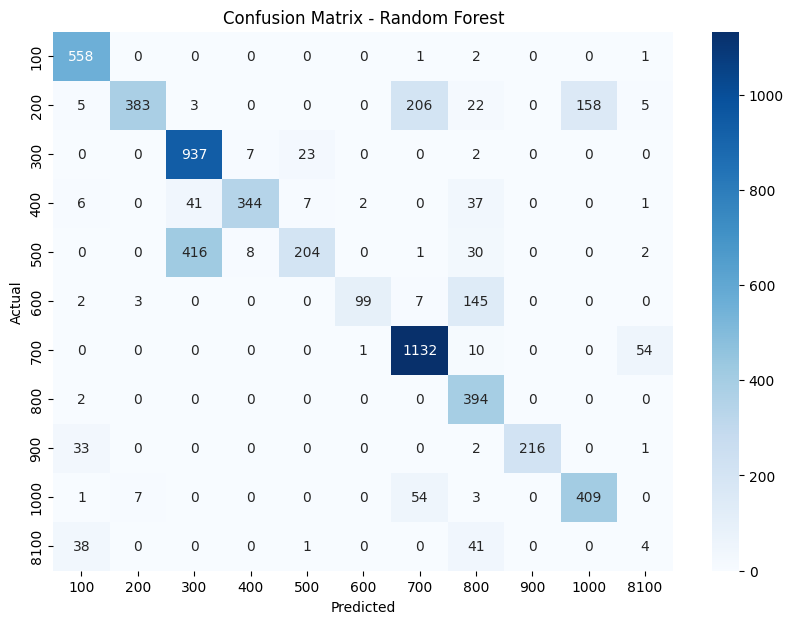


🔍 Đang huấn luyện mô hình: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUROC của Logistic Regression: 0.9651
              precision    recall  f1-score   support

         100       0.84      0.93      0.88       562
         200       0.89      0.69      0.78       782
         300       0.69      0.77      0.73       969
         400       0.96      0.89      0.93       438
         500       0.61      0.26      0.36       661
         600       0.71      0.62      0.66       256
         700       0.83      0.91      0.87      1197
         800       0.61      0.88      0.72       396
         900       0.85      0.84      0.85       252
        1000       0.75      0.85      0.80       474
        8100       0.14      0.30      0.19        84

    accuracy                           0.76      6071
   macro avg       0.72      0.72      0.71      6071
weighted avg       0.77      0.76      0.75      6071



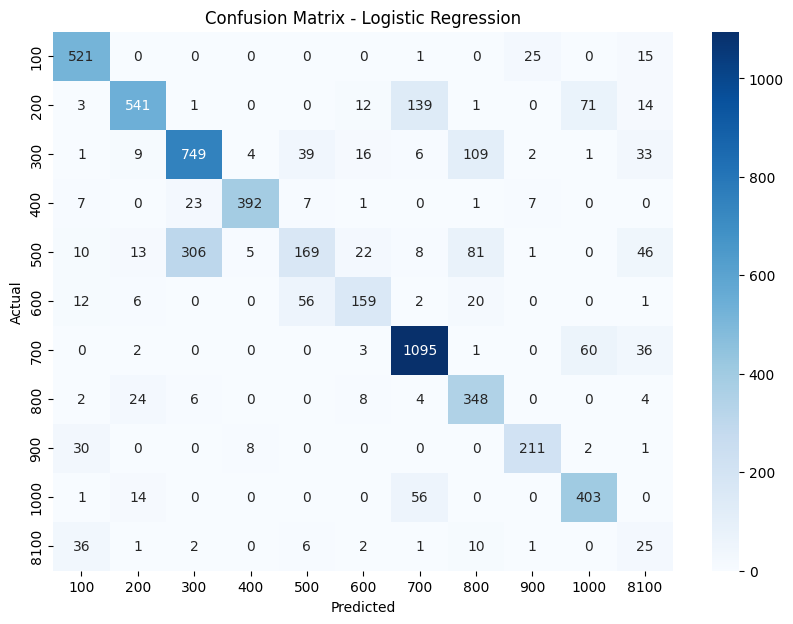


🔍 Đang huấn luyện mô hình: Extra Trees
AUROC của Extra Trees: 0.9649
              precision    recall  f1-score   support

         100       0.85      0.98      0.91       562
         200       0.99      0.51      0.67       782
         300       0.67      0.97      0.79       969
         400       0.96      0.89      0.93       438
         500       0.85      0.30      0.44       661
         600       0.95      0.32      0.48       256
         700       0.81      0.99      0.89      1197
         800       0.63      0.99      0.77       396
         900       1.00      0.85      0.92       252
        1000       0.75      0.91      0.83       474
        8100       0.26      0.08      0.13        84

    accuracy                           0.79      6071
   macro avg       0.79      0.71      0.70      6071
weighted avg       0.82      0.79      0.76      6071



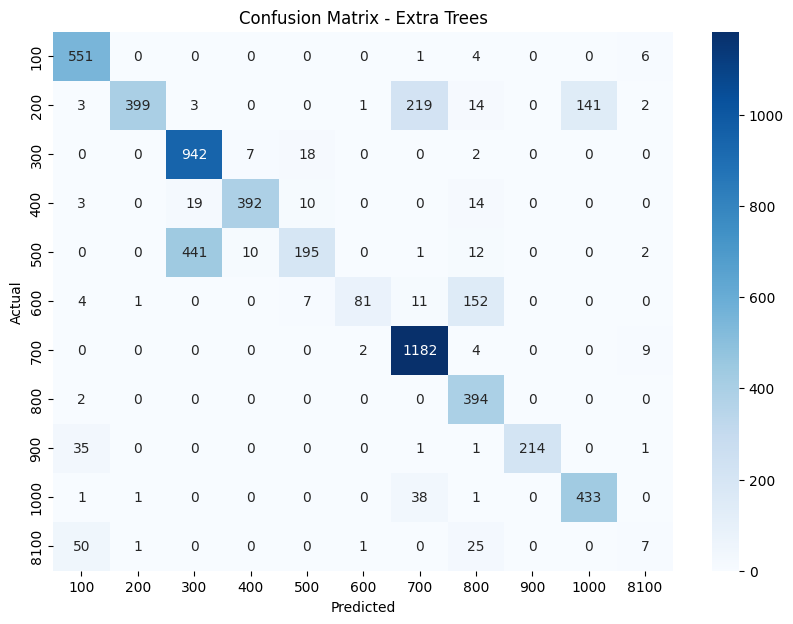


🔍 Đang huấn luyện mô hình: KNN (K-Nearest Neighbors)
AUROC của KNN (K-Nearest Neighbors): 0.7879
              precision    recall  f1-score   support

         100       0.50      0.87      0.64       562
         200       0.44      0.39      0.41       782
         300       0.57      0.20      0.30       969
         400       0.86      0.61      0.71       438
         500       0.28      0.15      0.20       661
         600       0.12      0.22      0.16       256
         700       0.64      0.61      0.63      1197
         800       0.41      0.45      0.43       396
         900       0.86      0.47      0.61       252
        1000       0.47      0.63      0.54       474
        8100       0.01      0.11      0.03        84

    accuracy                           0.45      6071
   macro avg       0.47      0.43      0.42      6071
weighted avg       0.52      0.45      0.46      6071



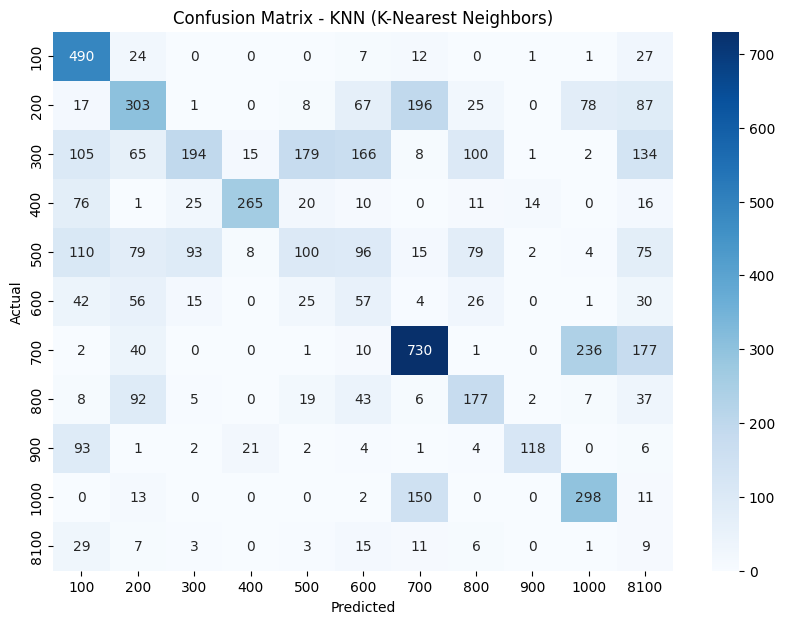


🔍 Đang huấn luyện mô hình: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:30:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:30:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


AUROC của XGBoost: 0.9461
              precision    recall  f1-score   support

         100       0.61      0.99      0.76       562
         200       0.98      0.24      0.39       782
         300       0.64      0.96      0.77       969
         400       0.92      0.80      0.86       438
         500       0.66      0.21      0.31       661
         600       0.97      0.15      0.26       256
         700       0.75      0.76      0.75      1197
         800       0.57      0.99      0.72       396
         900       1.00      0.89      0.94       252
        1000       0.57      0.86      0.69       474
        8100       0.15      0.04      0.06        84

    accuracy                           0.68      6071
   macro avg       0.71      0.63      0.59      6071
weighted avg       0.74      0.68      0.64      6071



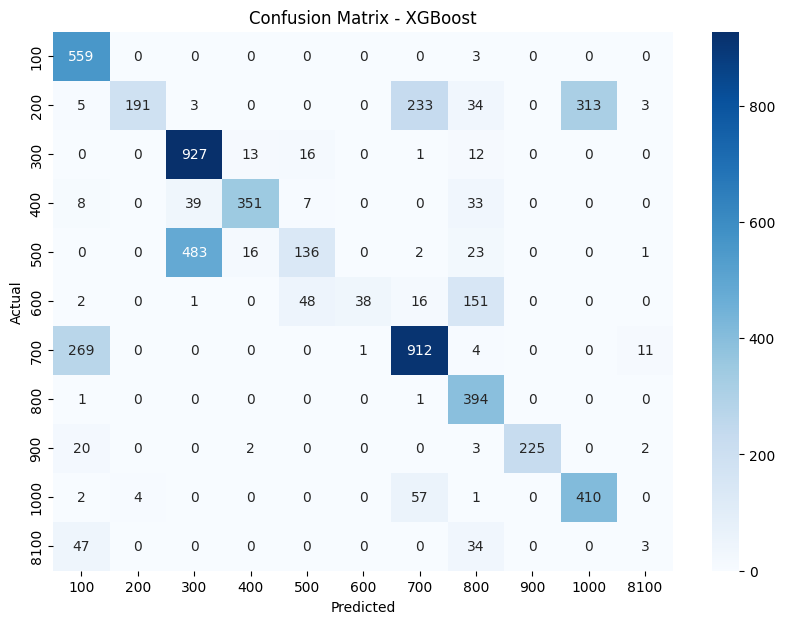


🔍 Đang huấn luyện mô hình: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16883
[LightGBM] [Info] Number of data points in the train set: 93687, number of used features: 70
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

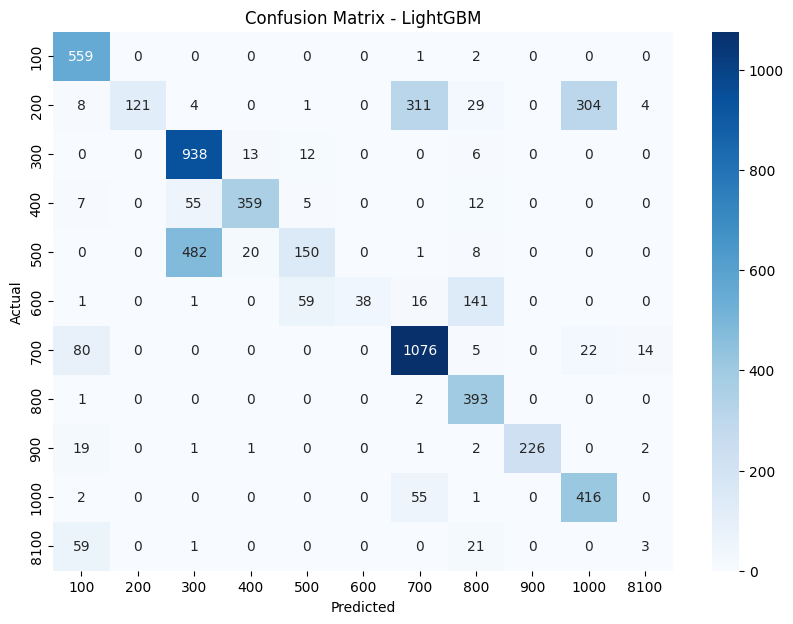

In [74]:
# Các model sẽ thử nghiệm
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier
     (
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        tree_method='hist',
        device='cuda'
    ),
    "LightGBM": LGBMClassifier
     (
        n_estimators=200,
        learning_rate=0.1
      )
}

# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\n🔍 Đang huấn luyện mô hình: {model_name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_encoded = model.predict(X_test)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        if len(np.unique(y_test_encoded)) == 2:
            auc = roc_auc_score(y_test_encoded, y_pred_proba[:, 1], average='macro')
        else:
            auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
        print(f"AUROC của {model_name}: {auc:.4f}")
    else:
        print(f"{model_name} không hỗ trợ predict_proba().")

    print(classification_report(y_test_original, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test_original, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()